In [1]:
%load_ext autoreload
%autoreload 2

# MERQUACO
This notebook is meant as a comprehensive guide for using **merquaco**, covering all of the relevant functionality and different use cases. Refer to our [docs](https://merquaco.readthedocs.io/en/latest/api.html) for additional information.
- Functions for each QC metric are broken up into discrete modules, and the notebook will go through these sequentially.
    - But first, we'll go over the `run_all_qc()` method.
- Most of **merquaco**'s functionality requires only the `detected_transcripts.csv` transcripts table file, with the exception of `FOVDropout` in `data_loss.py`, and parts of the `pixel_classification.py` workflow.
    - `data_loss` requires the pixel classification workflow to be run through `ilastik` (refer to ilastik tutorial for more info), as well as access to the codebook.csv file for the given experiment.
    - To run the entire `pixel_classification.py` workflow, a high-res DAPI image (e.g., `mosaic_DAPI_z0.tiff`) is required.
        - Installing ilastik (<https://www.ilastik.org/download>) and including the path to the ilastik program is also necessary.

### Installation
Move the the directory in which you downloaded **merquaco** and pip install:

    `$ pip install .` 

### Import merquaco

In [2]:
import merquaco as mqc
from pathlib import Path
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
import os

### Creating an Experiment object
- The `Experiment` object is initialized with the `detected_transcripts.csv` file, with either a path to the file, or with an already-processed dataframe.
- `Experiment` objects are the main instance used for storing experiment information and QC metrics, including:
    - basic experiment dataframes (transcripts dataframe, FOVs dataframe)
    - basic experiment data (number of transcripts detected, number of z-planes imaged, number of genes in panel, etc.)
    - (optional) QC metrics (periodicity, 9/0 ratio, dropped FOVs, etc.)
    - (optional) paths to data (e.g., DAPI image, perfusion log file, codebook, etc.)
    - (optional) paths to save **merquaco** outputs (e.g., binary mask paths, main output directory)

In [3]:
#path_to_transcripts = 'path/to/your_experiment/detected_transcripts.csv' 

In [4]:
# Initialize with path
exp = mqc.experiment.Experiment(path_to_transcripts)

# Initialize with dataframe
# exp = mqc.experiment.Experiment(exp.filtered_transcripts)  # This is a dataframe of transcripts read in from the path above, with 'Blank-##' codewords "filtered" out.

Processing transcripts dataframe
Filtering Blank codewords
Creating FOVs dataframe


`Experiment` objects automatically read the transcripts dataframe and remove 'Blank-' codewords. Let's take a look at some experiment attributes:

In [5]:
print(f'This experiment contains {exp.total_transcripts_counts} transcripts, and {exp.total_transcripts_counts - exp.filtered_transcripts_count} of them are Blank codewords, for a total of {exp.filtered_transcripts_count} "filtered" transcripts. \nThis is the dataframe we\'ll usually be working with!')

This experiment contains 100561480 transcripts, and 500398 of them are Blank codewords, for a total of 100061082 "filtered" transcripts. 
This is the dataframe we'll usually be working with!


The `exp.filtered_transcripts` dataframe contains gene identity and (x,y,z,fov) location for every detected transcript.

For our purposes, we use the global coordinates, and ignore `x`, `y`, `transcript_id`, and `barcode_id` columns.

In [6]:
exp.filtered_transcripts.head()

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id
0,177696,47,96.899062,8841.431016,5.0,1002.61560,485.55313,0,Fgf10,ENSMUST00000022246
1,225080,62,161.427276,8836.371016,0.0,1600.09900,438.70575,0,Tac2,ENSMUST00000026466
2,307000,81,175.720796,8959.905016,4.0,1732.44650,1582.53550,0,Lrp4,ENSMUST00000028689
3,309026,81,78.310916,8880.620016,6.0,830.50320,848.41640,0,Lrp4,ENSMUST00000028689
4,509291,141,3.139059,8936.893016,0.0,134.46742,1369.46960,0,Necab1,ENSMUST00000041606


The `exp.fovs_df` dataframe contains (x,y) coordinates, neighbor information, and transcript information (per gene, per z-plane) for each FOV.

In [7]:
exp.fovs_df.head()

,x_min,y_min,x_max,y_max,width,height,center_x,center_y,transcripts_count,z0_count,...,Wnt7b,Zbtb16,Zeb2,Zfhx4,Zfp521,Zfp536,Zfpm2,Zic1,Zic4,Zic5
fov,,,,,,,,,,,,,,,,,,,,,
0,2.709098,8806.115016,184.695056,8971.730016,181.985958,165.615,93.702077,8888.922516,17,NaN,...,0,0,0,0,0,0,0,0,0,0
1,8.599202,8601.735016,150.076576,8775.752016,141.477374,174.017,79.337889,8688.743516,13,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,8408.869016,198.728496,8592.735016,198.728496,183.866,99.364248,8500.802016,19,1.0,...,0,0,0,0,0,0,0,0,0,0
3,11.804011,8204.686016,195.392676,8389.252016,183.588665,184.566,103.598344,8296.969016,17,NaN,...,0,0,0,0,0,0,0,0,0,0
4,202.998656,4410.285016,366.274016,4594.492016,163.275360,184.207,284.636336,4502.388516,12,NaN,...,0,0,0,0,0,0,0,0,0,0


## Running all QC
- If we have all of the required input information (ilastik program, DAPI image, codebook), then `exp.run_all_qc()` is the most useful and comprehensive method in **merquaco**. It will:
  - Run the **pixel classification** workflow, identifying every region of your section as either tissue, gel detachment, tissue damage, or ventricles.
  - Look for **data loss** in FOVS. *This requires the codebook and tissue mask generated in the pixel classification workflow.*
  - Gather on-tissue metrics: **on-tissue transcript density per square micron (per gene).**
  - Compute **transcript detection nonuniformity metrics**:
      - **Periodicity**: measure of spatially nonuniform transcript detection in (x,y) within FOVs
      - **9/0 Ratio**: measure of spatially nonuniform transcript detection in z-axis across tissue
  - Analyze perfusion log file for **flow rate** deviations.
  - Plot and save figures/metrics

In [8]:
# # First, let's define all the necessary experiment parameters
# ilastik_program_path = Path('path/to/your_ilastik_program/ilastik-1.4.0-Linux/run_ilastik.sh')
# dapi_high_res_image_path = Path('path/to/your_vizgen_output/region_0/images/mosaic_DAPI_z0.tif')
# codebook_path = Path('path/to/your_gene_panel_codebook.csv')

In [9]:
# Initialize experiment object with all necessary parameters
exp = mqc.experiment.Experiment(transcripts_input = exp.filtered_transcripts,  # Can be dataframe or path to `detected_transcripts.csv`
                                ilastik_program_path = ilastik_program_path,  # Path to directory including ilastik program
                                dapi_high_res_image_path = dapi_high_res_image_path,  # Path to `mosaic_DAPI_z0.tif` image (MERSCOPE output)
                                codebook_input = codebook_path,  # Can be dataframe or path to codebook .csv file
                                perfusion_path = perfusion_path,  # Path to experiment log file REMOVE!!!!
                                output_dir = Path(os.getcwd(), 'qc_output'))  # Path at which to save merquaco outputs
                                

Processing transcripts dataframe
Filtering Blank codewords
Creating FOVs dataframe
Reading in transcript mask


Generating DAPI mask...
Generating lifting mask...
Generating ventricle mask...
Generating damage mask...
Classifying pixels...


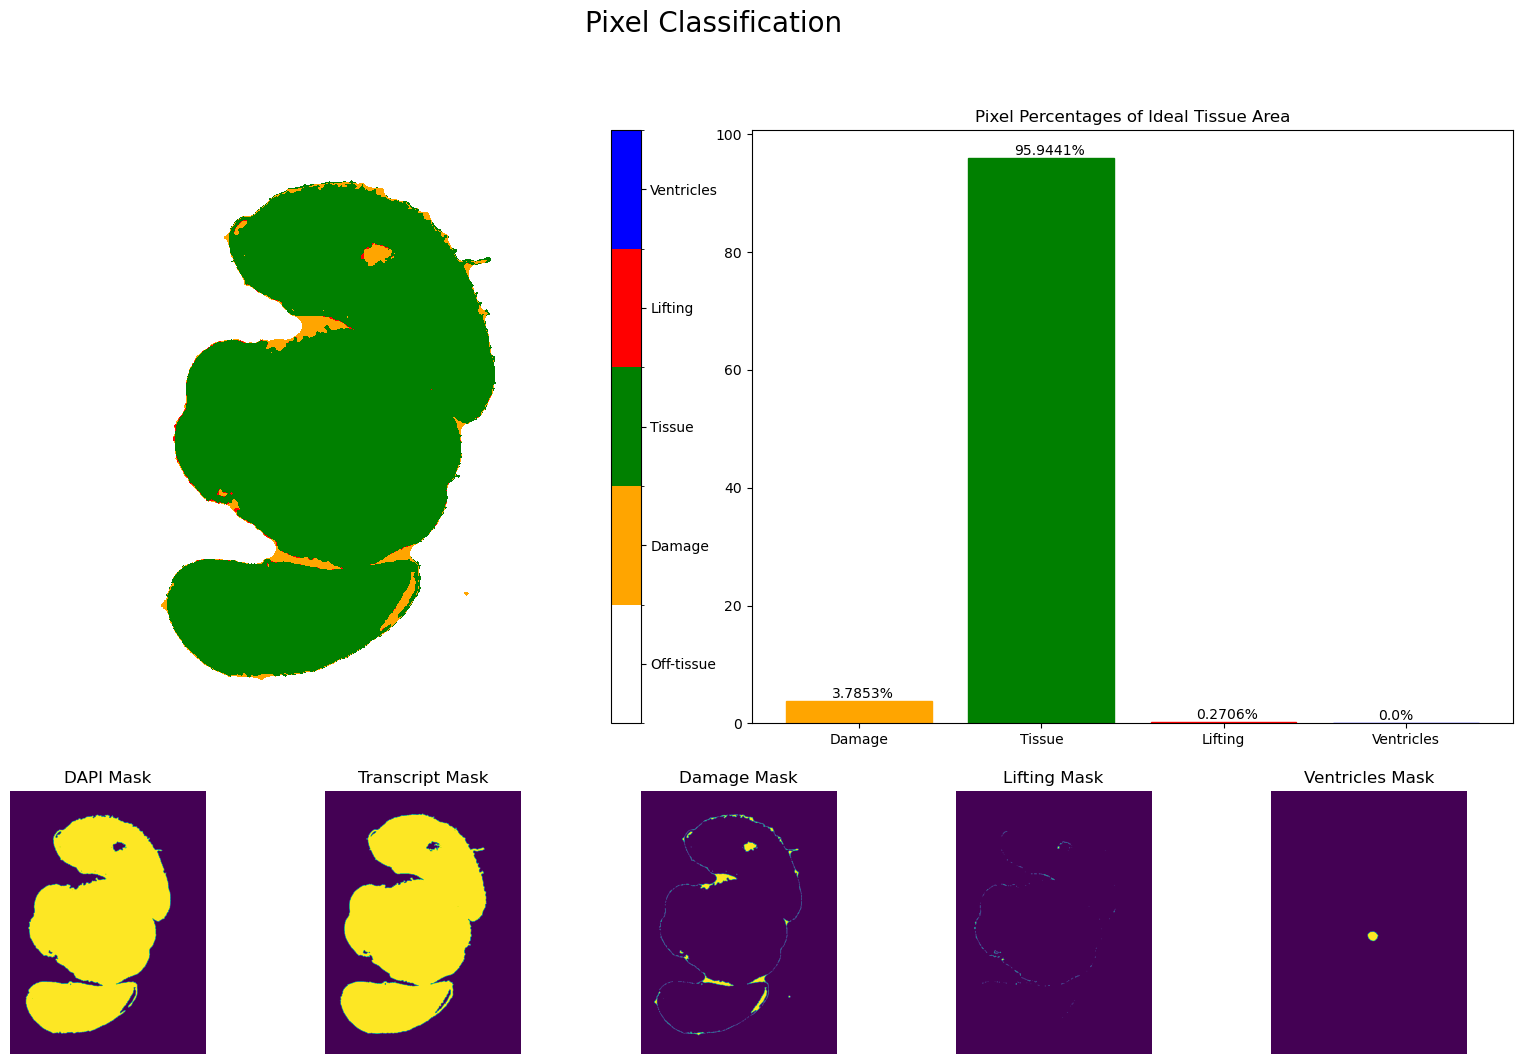

Beginning FOV Dropout Detection


/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/merfish_qc/merquaco/merquaco/data_loss.py:305: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  round_df = codebook.groupby((np.arange(bits) // 3) + 1, axis=1).sum()


Calculating periodicity


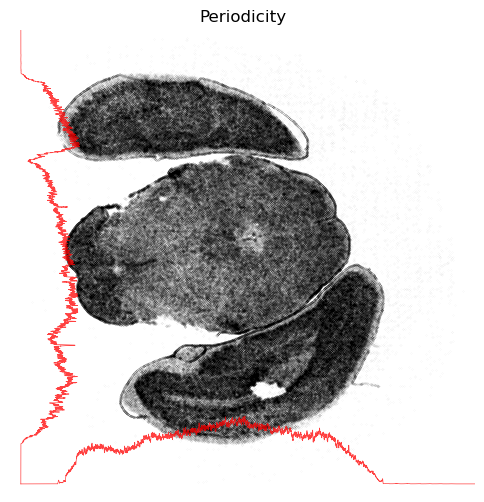

Computing z-plane metrics


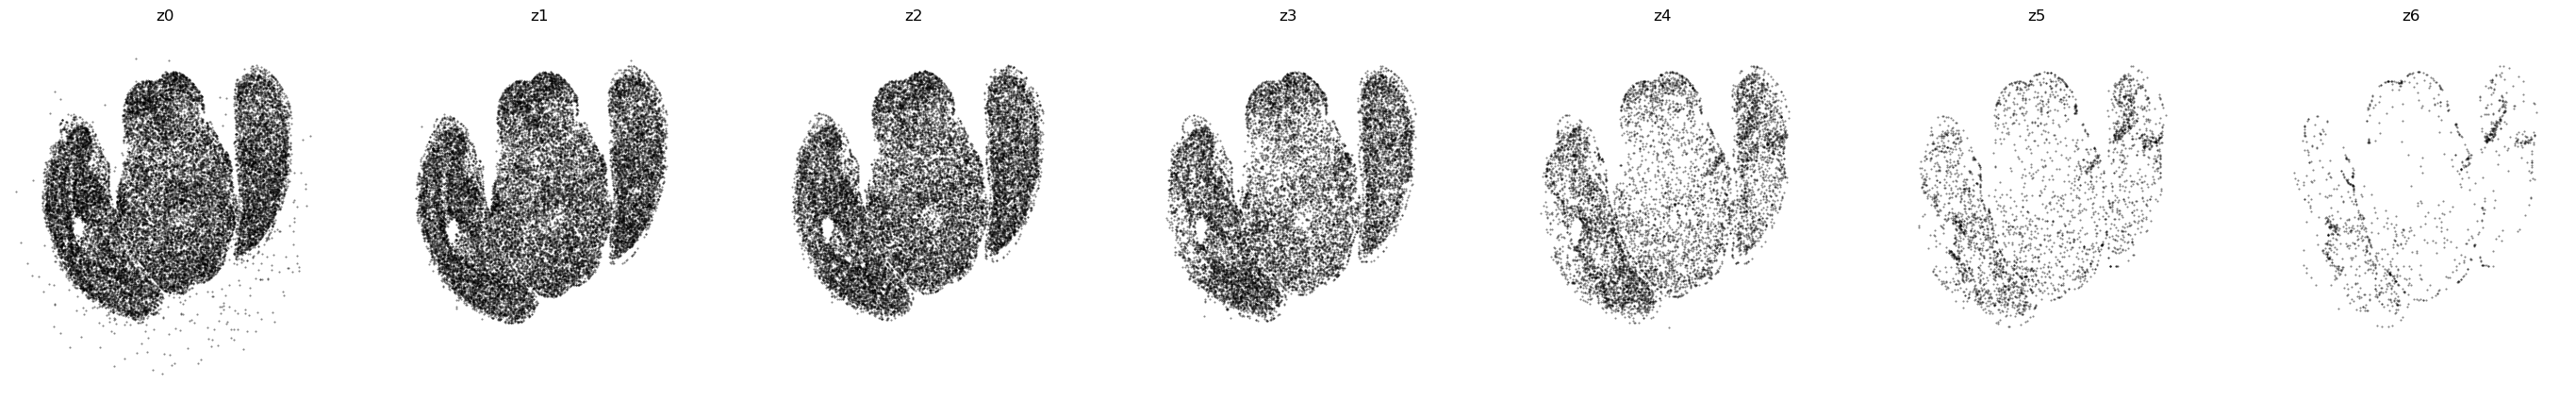

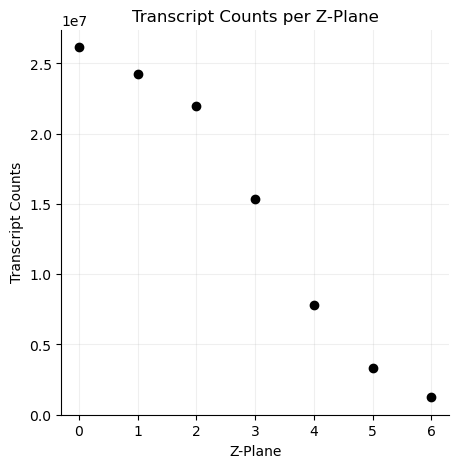

In [10]:
# Run all QC! This will likely take a few minutes
exp.run_all_qc(run_pixel_classification=True,
               run_dropout=True,
               run_perfusion=False, #REMOVE
               plot_figures=True,
               save_metrics=True)

# Individual Metrics

With our pre-initialized `Experiment` object, we'll compute individual QC metrics.

## On-Tissue Metrics
- The binary tissue mask generated with ilastik during the `Experiment` initialization is a good approximation of the tissue boundary:

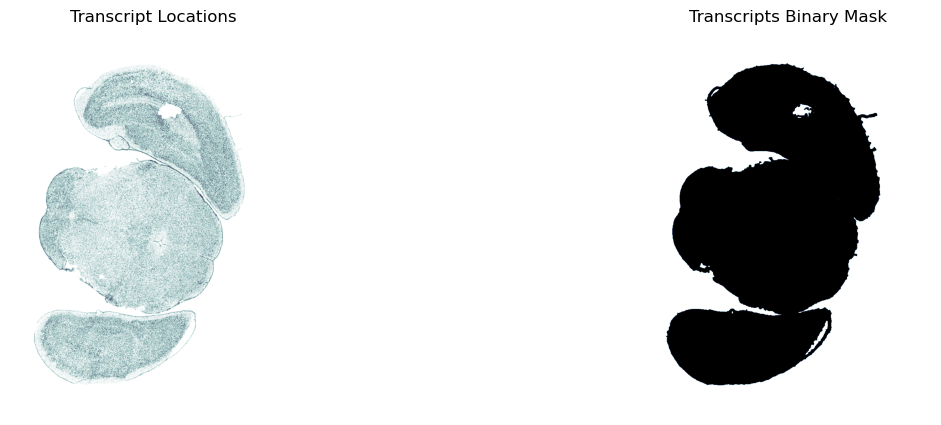

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ts_image = tiff.imread('qc_output/transcripts.tiff')
ts_mask = tiff.imread('qc_output/transcripts_mask.tiff')

ax[0].imshow(ts_image, cmap='bone_r')
ax[0].axis('off')
ax[0].set_title('Transcript Locations')
ax[1].imshow(ts_mask, cmap='bone_r')
ax[1].axis('off')
ax[1].set_title('Transcripts Binary Mask')

plt.show()

- We use this area to compute the transcript density per on-tissue square micron:

In [12]:
transcript_density = mqc.experiment.Experiment.get_transcript_density(ts_image, ts_mask)

- To aid comparison between experiments using different gene panels, we normalize by number of genes probed:

In [13]:
transcript_density_per_gene = transcript_density / exp.n_genes
# These numbers may be unintuitive, but with a large enough number of experiments to compare to, can be a good initial check of experiment quality
print(f'Transcript density per square micron: {np.round(transcript_density, 3)}\nTranscript density per square micron per gene: {np.round(transcript_density_per_gene, 3)}')

Transcript density per square micron: 2.695
Transcript density per square micron per gene: 0.005


## Data Loss
- Occasionally, individual field of view tiles are missing transcripts for a subset of genes. We can find the missing FOVs and missing genes using `mqc.experiment.Experiment.run_dropout_pipeline()`, which saves the data loss information in a dataframe (`fovs.txt.gz`).
- We can read in this dataframe take a look at the result.
    - Begin by initializing a `DropoutResult` object with the dataframe and transcripts table.

In [14]:
drop = mqc.data_loss.DropoutResult('fovs.txt.gz', exp.filtered_transcripts)
# Take a look at the FOVs dataframe
drop.fovs.head()

,x_min,y_min,x_max,y_max,width,height,center_x,center_y,transcripts_count,z0_count,...,transcript_threshold_Pax8,deltas_Pax8,dropout_Pax8,transcript_threshold_Piezo2,deltas_Piezo2,dropout_Piezo2,transcript_threshold_Hoxb3,deltas_Hoxb3,dropout_Hoxb3,false_positive
fov,,,,,,,,,,,,,,,,,,,,,
0,44.416403,5309.44657,116.51768,5502.55197,72.101277,193.1054,80.467041,5405.99927,9,NaN,...,False,[],False,False,[],False,False,[],False,NaN
1,0.000000,5150.73667,166.78458,5291.57497,166.784580,140.8383,83.392290,5221.15582,5,1.0,...,False,[],False,False,[],False,False,[],False,NaN
2,118.680130,5071.34597,175.20484,5074.47147,56.524710,3.1255,146.942485,5072.90872,2,NaN,...,False,[],False,False,[],False,False,[],False,NaN
3,24.215346,4718.94267,170.46164,4901.70097,146.246294,182.7583,97.338493,4810.32182,16,NaN,...,False,[],False,False,[],False,False,[],False,NaN
4,208.269150,3751.79617,303.64122,3835.40727,95.372070,83.6111,255.955185,3793.60172,8,NaN,...,False,[],False,False,[],False,False,[],False,NaN


#### Get the data loss summary

In [15]:
drop.dropout_summary()

0 unique FOVs were dropped out of 1226 considered FOVs (0.00%)
FOVs with dropout dropped out in 0.00 genes on average out of possible total of 345 (0.00%)
0 genes were affected by dropout out of 345 possible (0.00%)
Genes with dropout averaged 0.00 dropped FOVs out of 1226 possible FOVs (0.00%)


Or, we can get each of these values individually:

In [16]:
print(drop.get_dropped_fov_counts())      # Number of FOVs with data loss
print(drop.get_considered_fov_counts())   # Number of FOVs eligible for data-loss (e.g., on-tissue, non-empty)
print(drop.get_dropped_gene_counts())     # Number of unique genes lost
print(drop.get_considered_gene_counts())  # Number of genes eligible for data loss

0
1226
0
345


#### Visualize dropped FOVs, and how many genes dropped per FOV

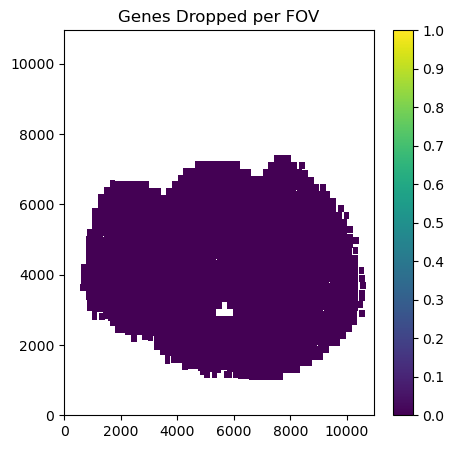

In [17]:
drop.draw_genes_dropped_per_fov()

#### Visualize data loss for a single gene

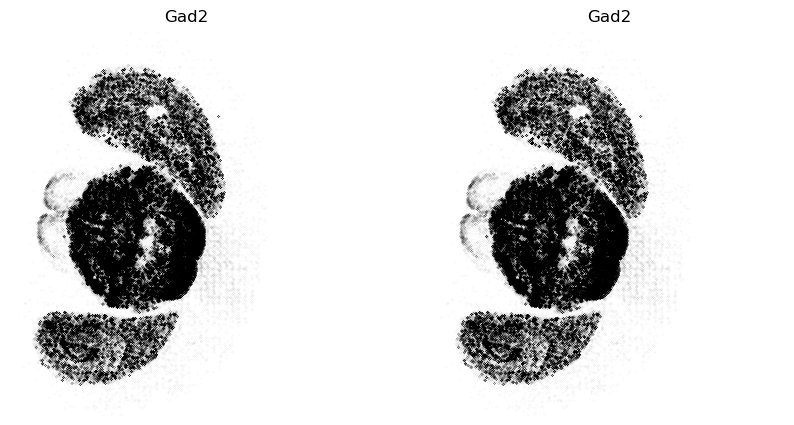

In [18]:
drop.draw_dropout('Gad2')

## Spatially Nonuniform Transcript Detection
We observe nonuniform transcript detection in the x-, and y-axes within FOV tiles

### Nonuniform Detection in Z: 9/0 Ratio
- In principle, a 10um slice of tissue should have similar transcript detection in every z-plane
    - In practice, we see lower transcript detection in the z-planes further from the coverslip
    - We compute our z-plane nonuniformity metric by dividing the transcript counts in the highest z-stack (z6, 9um from coverslip) by the transcript counts in the lowest z-stack (z0, 0um from coverslip)

In [19]:
z_ratio = mqc.z_plane_detection.compute_z_ratio(exp.filtered_transcripts, num_planes=7)
z_ratio

0.047

We can visualize transcript counts per z-stack in a few ways:

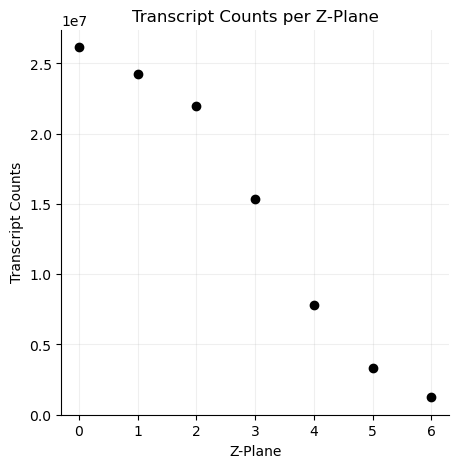

In [20]:
transcripts_per_z = mqc.z_plane_detection.get_transcripts_per_z(exp.filtered_transcripts)
mqc.figures.plot_transcripts_per_z(transcripts_per_z)

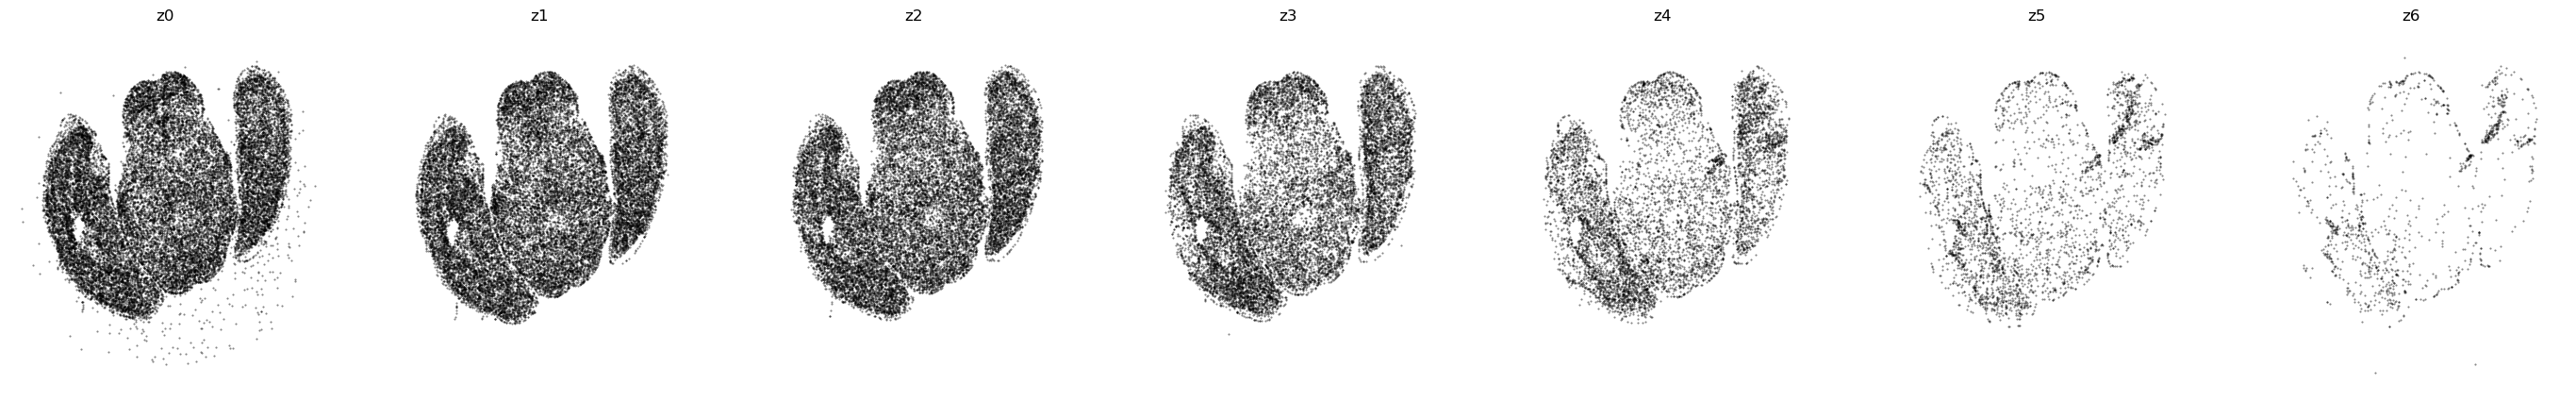

In [21]:
mqc.figures.plot_every_z_plane(exp.filtered_transcripts)

#### Nonuniform Detection in x, y: Periodicity Metric
- When present and severe, nonuniform detection in the x- and y-axes manifests as a grid-like "checkerboard" pattern across the section
- We compute the periodicity metric in x- and y-axes separately for each z-stack:

In [22]:
periodicity_vals = mqc.periodicity.get_periodicity_list(exp.filtered_transcripts)  # Default number of z-stacks (`num_planes`) is 7

In [23]:
periodicity_vals

[(0.9211149120299686, 0.9163863510065035),
 (0.9256829654928345, 0.9177673484777874),
 (0.9041519954623447, 0.900740476426622),
 (0.8499013372494876, 0.8919336497119105),
 (0.8360748069124256, 0.8108007936026912),
 (0.8070226375887611, 0.73223480005282),
 (0.7894872141074839, 0.6234650410094784)]

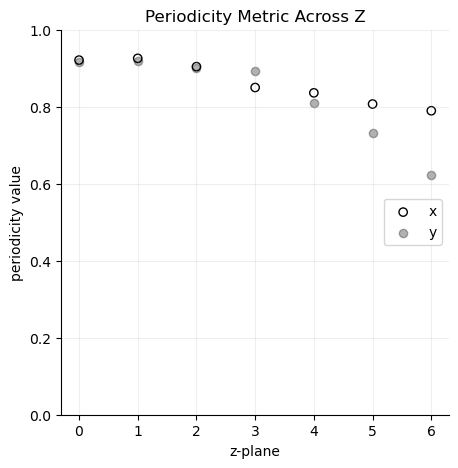

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(np.arange(0, 7, 1), [val[0] for val in periodicity_vals], facecolor='none', edgecolor='k', label='x')
ax.scatter(np.arange(0, 7, 1), [val[1] for val in periodicity_vals], color='k', alpha=0.3, label='y')

ax.set_ylim(0, 1)
ax.grid(which='both', alpha=0.2)
ax.set_ylabel('periodicity value')
ax.set_xlabel('z-plane')
ax.set_title('Periodicity Metric Across Z')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='center right')

plt.show()

# Pixel Classification
An image of the experiment is generated with all pixels classified into 4 labels: intact tissue, damaged tissue, detached tissue, ventricles. This workflow makes use of trained ilastik models to generate the transcripts, DAPI, and ventricles mask. These models are all installed with the merquaco package, but to use them you will need to download the ilastik program from their website.

This workflow is run with the full QC by default, but we can also run it on its own by calling the `run_full_pixel_classification()` method in the `Experiment` class. The figure won't automatically display, so we need to call on the `figures` module to plot it. 

Generating DAPI mask...
Generating lifting mask...
Generating ventricle mask...
Generating damage mask...
Classifying pixels...


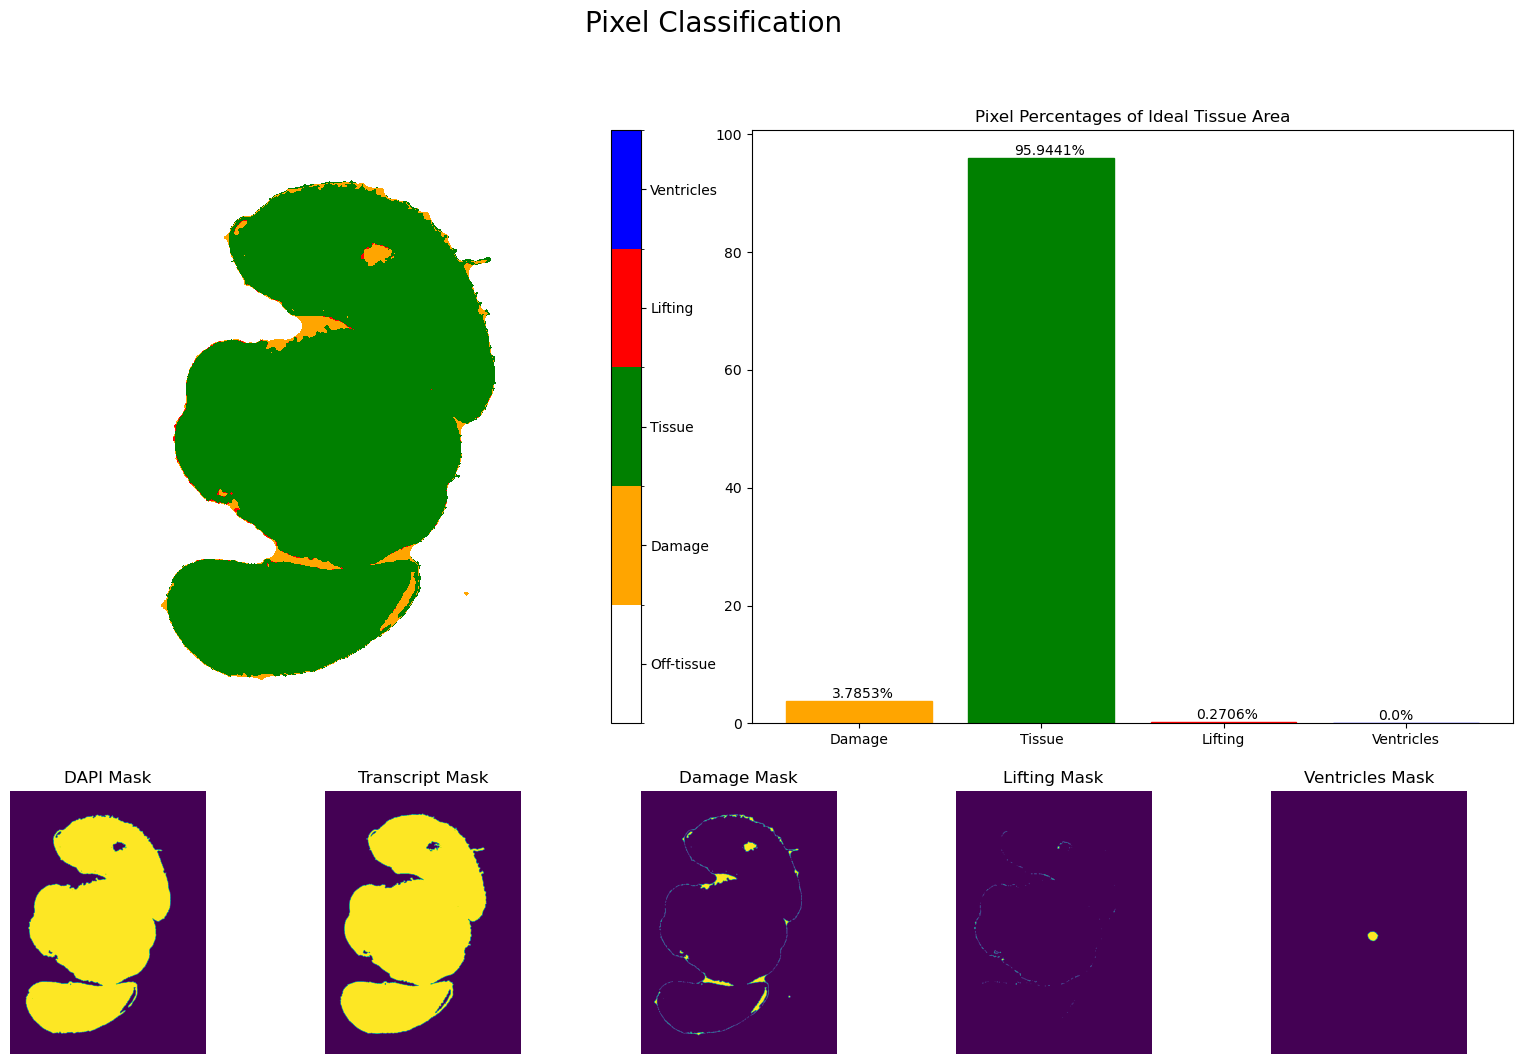

In [25]:
exp.run_full_pixel_classification()
mqc.figures.plot_full_pixel_fig(exp.pixel_classification, exp.dapi_mask, exp.transcripts_mask, exp.detachment_mask, exp.transcripts_percent, 
                                exp.detachment_percent, exp.damage_mask, exp.ventricle_mask, exp.damage_percent, exp.ventricle_percent)

We have selected a few ventricle marker genes present in some of our gene panels to generate the ventricle mask. You are welcome to input your own list of ventricle genes as a parameter in the Experiment object initialization. The workflow will use your list of genes to generate the ventricle image that will go through the ventricle mask ilastik model.